In [2]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from tqdm import tqdm
from functools import cache

See this website: https://blog.djnavarro.net/posts/2023-04-12_metropolis-hastings/#fnref10

# Problem 2

In [14]:
chain = []
steps = 1000

xn = np.array([-3])
chain.append(xn)
sigma = 1

rng = RNG(seed=100)
with tqdm(total=steps, position=0) as pbar:
    for i in range(steps):
        candidate = Normal(mu=xn.item(), sigma=sigma, rng=rng).sample(1)
        accept_ratio = min(1, p(candidate)/p(xn))
        test = Uniform(rng=rng).sample()
        if test < accept_ratio:
            xn = candidate
        chain.append(xn)
        pbar.update()

100%|██████████| 1000/1000 [00:00<00:00, 53547.27it/s]


In [15]:
# Implement Lehmers Algorithm for learning how it works, but I use np.random.uniform
def LehmersAlgorithm(seed=1, m=2**32-1, a=48271):
    assert 0 <= seed < m - 1
    zn = seed+1
    while True:
        zn = (a*zn) % m
        yield zn, m

def Uniform(a=0.0,b=1.0,seed=1,size=None):
    rng = LehmersAlgorithm(seed)
    def sampler(size=1):
        vals = np.empty(size).flatten()
        for i in range(len(vals)):
            zi, m = rng.__next__()
            ui = zi/m
            vals[i] = ui
        return a + vals * (b-a)
    if size is None:
        return sampler
    else:
        return sampler(size)

In [16]:
class RNG:
    def __init__(self, seed=0, m=2**32-1, a=7**5, c=0):
        assert 0 <= seed < m-1
        assert 0 <= a < m 
        assert 0 <= c < m 
        
        self.seed = seed + 1 
        self.m = m 
        self.a = a 
        self.c = c
        self.zn = self.seed 
    
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.lehmer()
        
    def lehmer(self):
        self.zn = (self.a*(self.zn + self.c)) % self.m
        return self.zn 
    
class NumpyRNG:
    def __init__(self, rng=None):
        if rng is None:
            rng = np.random.default_rng()
        self.rng = rng
        self.m = 1 
        
    def __iter__(self):
        return self 
    
    def __next__(self):
        return self.rng.uniform()
        
class Distribution:
    def __init__(self, rng=None):
        if rng is None:
            rng = RNG()
            
        self.rng = rng
    
    def cdf(self, x):
        raise NotImplementedError()
    
    def pdf(self, x):
        raise NotImplementedError()
    
    def invcdf(self, u):
        raise NotImplementedError()
    
    def __iter__(self):
        return self 
    
    def __next__(self):
        return self.sample(1)
    
    def checkshape(self, shape=1):
        if isinstance(shape, int):
            length = shape 
            shape = (shape,)
        elif isinstance(shape, list):
            length = np.prod(shape)
            shape = shape 
        else:
            raise ValueError(shape)  
        return length, shape
    
    def sample(self, shape=1):
        length, shape = self.checkshape(shape)
        vals = np.zeros(length)
        for n, val in zip(range(length), self.rng):
            vals[n] = val / self.rng.m 
        if shape == 1:
            vals = vals.item()
        vals = vals*(1 - 2*np.finfo(float).eps) + np.finfo(float).eps
        return vals
    
class Uniform(Distribution):
    def __init__(self, a=0, b=1, rng=None):
        super().__init__(rng)
        self.a = a
        self.b = b 
        assert self.b > self.a
    
    def pdf(self, x):
        if x < self.a or x > self.b:
            return 0
        return 1/(self.b - self.a)
    
    def logpdf(self, x):
        if x < self.a or x > self.b:
            return -np.inf 
        else:
            return -np.log(self.b - self.a) 
        
    def cdf(self, x):
        if x < self.a:
            return 0
        elif self.a <= x <= self.b:
            return (x - self.a)/(self.b - self.a)
        else:
            return 1
    
    def invcdf(self, u):
        return u*(self.b - self.a) + self.a 
    
    def sample(self, shape=1):
        vals = super().sample(shape=shape)
        vals = self.invcdf(vals)
        return vals
    
class Normal(Distribution):
    def __init__(self, mu=0, sigma=1, rng=None):
        super().__init__(rng)
        self.mu = mu 
        self.sigma = sigma 
        
    def pdf(self, x):
        return 1/(np.sqrt(2*np.pi)*self.sigma)*np.exp(-0.5*((x - self.mu)/self.sigma)**2)
    
    def logpdf(self, x):
        return -0.5*np.log(2*np.pi) - np.log(self.sigma) - 0.5*((x - self.mu)/(self.sigma))**2
    
    def cdf(self, x):
        return 0.5*(1 + sp.special.erf((x - self.mu)/(self.sigma*np.sqrt(2))))
    
    def invcdf(self, u):
        return self.mu + self.sigma*np.sqrt(2)*sp.special.erfinv(2*u-1)
        
    def sample(self, shape=1):
        vals = super().sample(shape=shape)
        if np.prod(shape) > 1:
            vals = np.array([self.invcdf(val) for val in vals]).reshape(shape)
        else:
            vals = self.invcdf(vals)
        return vals

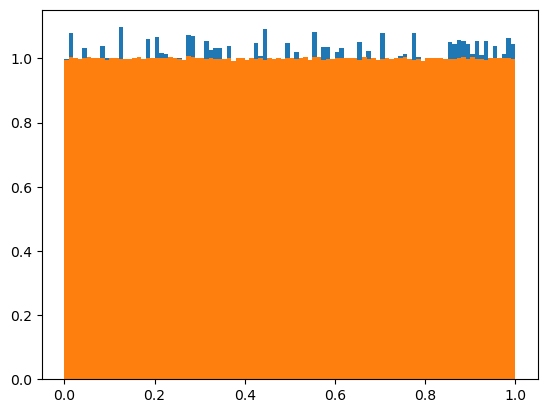

In [17]:
uniform = Uniform(a=0,b=1)
print(uniform.rng)
vals = uniform.sample(10000000)
plt.hist(vals, density=True, bins=100)
rng = np.random.Generator(np.random.PCG64())
plt.hist(rng.uniform(0,1,10000000), density=True, bins=100);

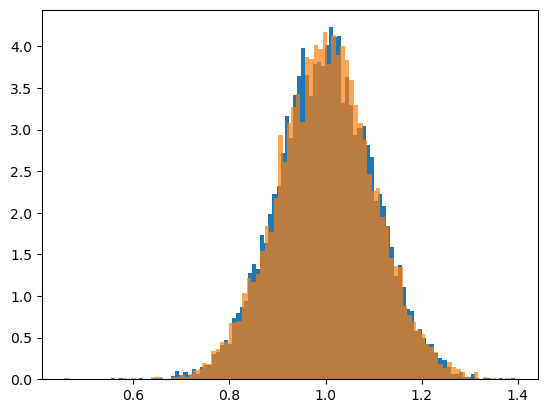

In [18]:
normal = Normal(mu=1,sigma=0.1)
vals = normal.sample(10000)
plt.hist(vals, density=True,bins=100)

rng = np.random.Generator(np.random.PCG64())
plt.hist(rng.normal(1,0.1,10000), bins=100, alpha=0.7, density=True);

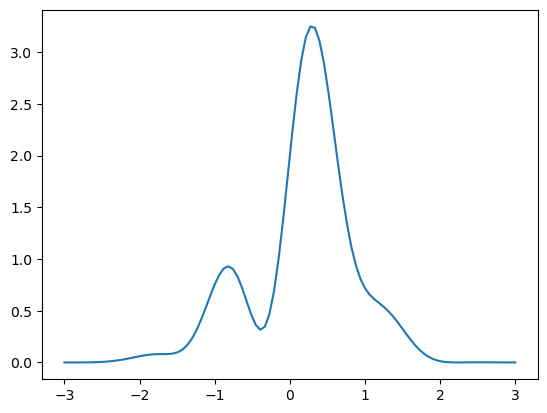

In [19]:
def p(x): return np.exp(-x**2)*(2 + np.sin(5*x) + np.sin(2*x))
particles = np.linspace(-3,3,100)
plt.plot(particles, p(particles))

Metropolis Hastings Algorithm

In [20]:
chain = []
steps = 1000

xn = np.array([-3])
chain.append(xn)
sigma = 0.1

rng = RNG(seed=25)
with tqdm(total=steps, position=0) as pbar:
    for i in range(steps):
        candidate = Normal(mu=xn.item(), sigma=sigma, rng=rng).sample(1)
        accept_ratio = min(1, p(candidate)/p(xn))
        test = Uniform(rng=rng).sample()
        if test < accept_ratio:
            xn = candidate
        chain.append(xn)
        pbar.update()

100%|██████████| 1000/1000 [00:00<00:00, 53774.51it/s]


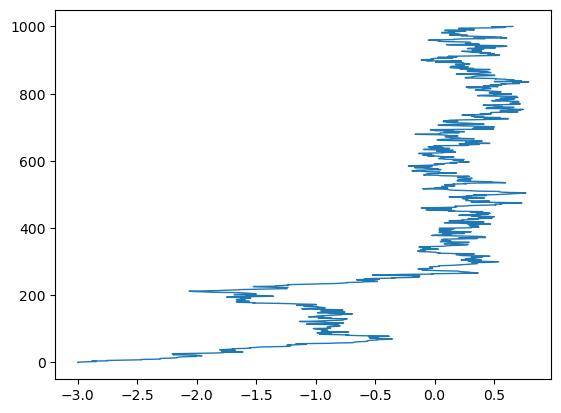

In [21]:
plt.plot(chain, range(len(chain)), linewidth=1)

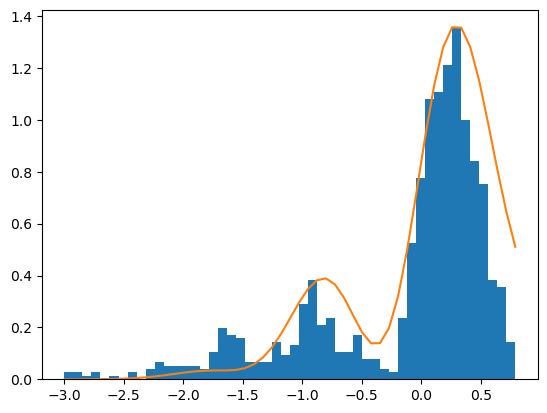

In [22]:
chain = np.array(chain)
pdf, particles, _ = plt.hist(chain, density=True, bins=50)
norm = np.trapz(pdf)

plt.plot(particles, p(particles)*np.max(pdf)/np.max(p(particles)))

In [23]:
import chaospy as cp
import inspect

In [24]:
def collect_subtypes(package, classes:tuple):
    subtypes = {}
    for key, val in package.__dict__.items():
        if inspect.isclass(val):
            for basedist in classes:
                if issubclass(val, basedist):
                    subtypes[key] = val 
        else:
            for basedist in classes:
                if isinstance(val, basedist):
                    subtypes[key] = val
    return subtypes

distributions = collect_subtypes(cp, (cp.Distribution,))

In [25]:
import scipy as sp
collect_subtypes(sp.stats, (sp.stats.rv_continuous, sp.stats.rv_discrete, sp.stats.rv_histogram))

{'rv_discrete': scipy.stats._distn_infrastructure.rv_discrete,
 'rv_continuous': scipy.stats._distn_infrastructure.rv_continuous,
 'rv_histogram': scipy.stats._continuous_distns.rv_histogram,
 'ksone': <scipy.stats._continuous_distns.ksone_gen at 0x77c5624fa090>,
 'kstwo': <scipy.stats._continuous_distns.kstwo_gen at 0x77c5624cf9b0>,
 'kstwobign': <scipy.stats._continuous_distns.kstwobign_gen at 0x77c562521a90>,
 'norm': <scipy.stats._continuous_distns.norm_gen at 0x77c562e102c0>,
 'alpha': <scipy.stats._continuous_distns.alpha_gen at 0x77c5639e4680>,
 'anglit': <scipy.stats._continuous_distns.anglit_gen at 0x77c5630ace30>,
 'arcsine': <scipy.stats._continuous_distns.arcsine_gen at 0x77c5630aedb0>,
 'beta': <scipy.stats._continuous_distns.beta_gen at 0x77c56223f320>,
 'betaprime': <scipy.stats._continuous_distns.betaprime_gen at 0x77c5630ae540>,
 'bradford': <scipy.stats._continuous_distns.bradford_gen at 0x77c56223d8e0>,
 'burr': <scipy.stats._continuous_distns.burr_gen at 0x77c5599e3

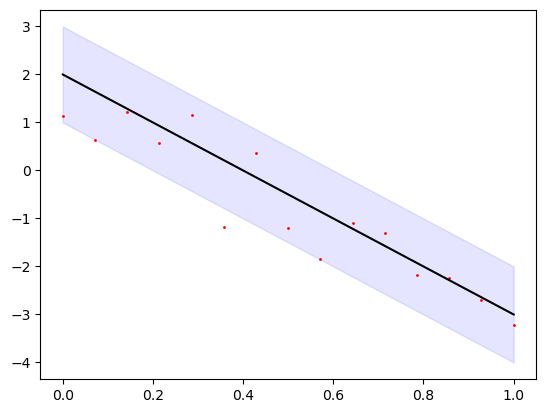

In [130]:
def model(t, m, b):
    return m*t + b 
def errmodel(t, sigma):
    return sigma*cp.Iid(cp.Normal(), len(t)).sample().reshape(len(t))
def likelihood(theta, t, Zobs):
    m, b, sigma = theta 
    Zhat = model(t, m, b)
    return 1/np.sqrt((2*np.pi)*sigma)**len(t)*np.exp(-0.5*(np.linalg.norm(Zhat - Zobs)/sigma)**2)
    
Nt = 15
t = np.linspace(0,1,Nt)
m_true, b_true = -5, 2 
sigma_true = 0.5
true_model = model(t, m_true, b_true)
true_err = errmodel(t, sigma_true)
Z_obs = true_model + true_err


plt.fill_between(t, true_model - 2*sigma_true, true_model + 2*sigma_true, color='b', alpha=0.1)
plt.plot(t, true_model, color='k')
plt.scatter(t, Z_obs, s=1, color='r')


In [149]:
mprior = cp.Uniform(-8,3)
bprior = cp.Normal(0,2)
sigmaprior = cp.InverseGamma(2,2) 
prior = cp.J(mprior,bprior,sigmaprior)
labels = ['m','b','sigma']

ntest = 1000
samples = prior.sample(ntest)

modelevals = np.zeros((len(t), ntest))
priorpredevals = np.zeros((len(t), ntest))
for n in range(ntest):
    modeleval = model(t,*samples[:2,n])
    erreval = errmodel(t, samples[2,n])
    modelevals[...,n] = modeleval 
    priorpredevals[...,n] = modeleval + erreval
    
modelint = np.zeros((2, len(t)))
priorpredint = np.zeros((2, len(t)))
for i in range(len(t)):
    modelhisti = np.histogram(modelevals[i])
    priorpredhisti = np.histogram(priorpredevals[i])
    modeldisti = sp.stats.rv_histogram(modelhisti)
    priorpreddisti = sp.stats.rv_histogram(priorpredhisti)
    modelint[...,i] = modeldisti.ppf([0.025,0.975])
    priorpredint[...,i] = priorpreddisti.ppf([0.025,0.975])

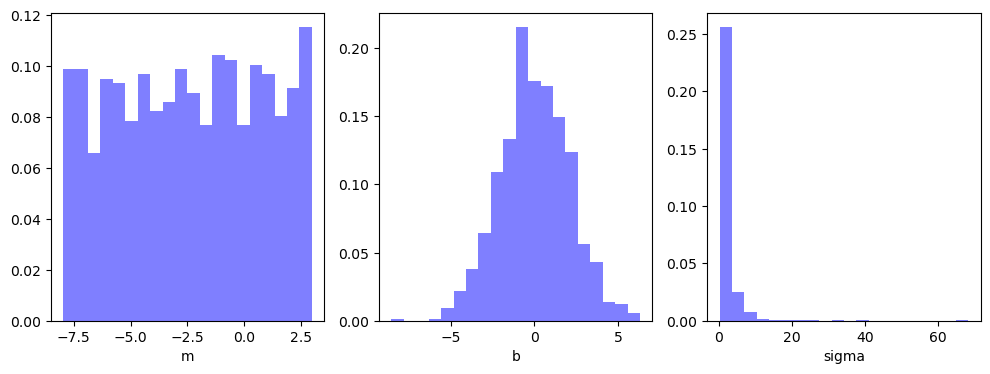

In [151]:
fig, ax = plt.subplots(1,len(prior), figsize=(4*len(prior),4))
for i in range(len(prior)):
    ax[i].hist(samples[i], bins=20, density=True, color='b', alpha=0.5)
    ax[i].set_xlabel(labels[i])

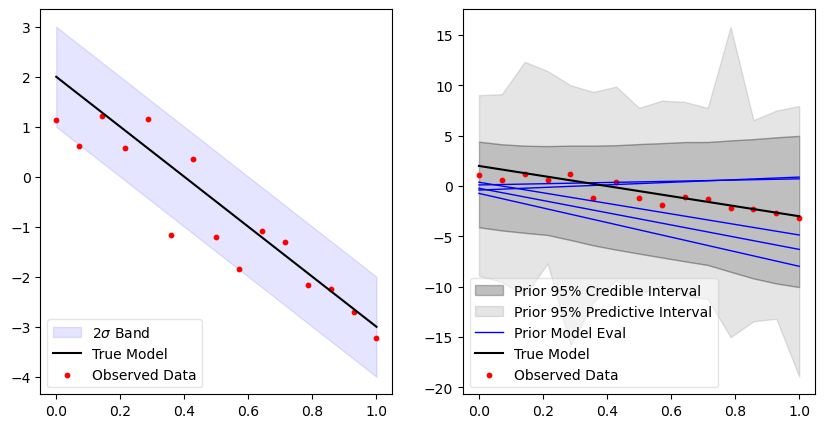

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].fill_between(t, true_model - 2*sigma_true, true_model + 2*sigma_true, color='b', alpha=0.1, label=r'2$\sigma$ Band')
ax[0].plot(t, true_model, color='k', label='True Model')
ax[0].scatter(t, Z_obs, s=10, color='r', label='Observed Data')
ax[0].legend(framealpha=0.5,loc='lower left')

Nplot = 5
plotinds = np.random.choice(range(ntest), Nplot, replace=False)

ax[1].fill_between(t, modelint[0], modelint[1], alpha=0.25, color='k', label='Prior 95% Credible Interval')
ax[1].fill_between(t, modelint[1], priorpredint[1], alpha=0.1, color='k', label='Prior 95% Predictive Interval')
ax[1].fill_between(t, priorpredint[0], modelint[0], alpha=0.1, color='k')
for i in range(Nplot):
    n = plotinds[i]
    modeleval = modelevals[...,n]
    label=None if i > 0 else 'Prior Model Eval'
    ax[1].plot(t, modeleval, color='b', linewidth=1, label=label)
    
ax[1].plot(t, true_model, color='k', label='True Model')
ax[1].scatter(t, Z_obs, s=10, color='r', label='Observed Data')

ax[1].legend(framealpha=0.5,loc='lower left')

In [153]:
def MetropolisHastings(
    prior, 
    likelihood, 
    niters=1000, 
    nburnin=100, 
    lag=1, 
    nchains=4, 
    sigma_proposal=0.1):
    
    d = len(prior)
    proposal = cp.Iid(cp.Normal(), d)
    test = cp.Uniform()
    
    particles = prior.sample(nchains)
    pi_particles = likelihood(*particles)*prior.pdf(particles)
    u = prior.fwd(particles)
    norm_samples = proposal.inv(u)
    
    chains = np.zeros((d, nchains, niters+1))
    chains[...,0] = particles
    
    naccepted = 0
    total = (niters + nburnin)
    with tqdm(total=total, position=0) as pbar:
        for j in range(total):
            
            i = j - nburnin
            for _ in range(lag):
                
                norm_candidates = norm_samples + sigma_proposal*proposal.sample(nchains)
                u = proposal.fwd(norm_candidates)
                candidates = prior.inv(u)
                pi_candidates = likelihood(*candidates)*prior.pdf(candidates)
                accept_ratio = np.clip(pi_candidates/pi_particles, 0, 1)
                
                for n in range(nchains):
                    if test.sample() < accept_ratio[n]:
                        particles[...,n] = candidates[...,n]
                        pi_particles[...,n] = pi_candidates[...,n]
                        naccepted += 1
            
            pbar.update()
            pbar.set_description(f'Accept ratio: {naccepted/((j+1)*lag*nchains)*100:.3f}%')
            if i >= 0:
                chains[...,i] = particles
    
    return chains


In [164]:
def MetropolisHastings(prior, likelihood, niters=1000, nburnin=500, lag=10, nchains=4, sigma_proposal=0.2):
    
    d = len(prior)
    proposal = cp.Iid(cp.Normal(), d)
    test = cp.Uniform()
    
    particles = prior.sample(nchains)
    pi_particles = prior.pdf(particles)
    
    for n in range(nchains):
        particle = particles[...,n]
        pi_particles[n] *= likelihood(*particle)
    u = prior.fwd(particles)
    norm_particles = proposal.inv(u)
    
    chains = np.zeros((d, nchains, niters+1))
    chains[...,0] = particles
    
    naccepted = 0
    total = (niters + nburnin)
    with tqdm(total=total, position=0) as pbar:
        for j in range(total):
            for _ in range(lag):
                
                norm_candidates = norm_particles + sigma_proposal*proposal.sample(nchains)
                u = proposal.fwd(norm_candidates)
                candidates = prior.inv(u)
                pi_candidates = prior.pdf(candidates)
                accept_ratio = np.clip(pi_candidates/pi_particles, 0, 1)
                
                for n in range(nchains):
                    norm_candidate = norm_candidates[...,n]
                    candidate = candidates[...,n]
                    pi_particle = pi_particles[...,n]
                    pi_candidate = pi_candidates[...,n]
                    
                    if pi_candidate == 0: continue 
                    pi_candidate *= likelihood(*candidate)
                    accept_ratio = min(1, pi_candidate/pi_particle)
                    
                    if test.sample() < accept_ratio:
                        particles[...,n] = candidate
                        norm_particles[...,n] = norm_candidate
                        pi_particles[...,n] = pi_candidate
                        naccepted += 1
                        
            i = j - nburnin
            if i >= 0:
                chains[...,i] = particles
            
            pbar.update()
            pbar.set_description(f'Accept ratio: {naccepted/((j+1)*lag*nchains)*100:.3f}%')
    
    return chains

chains = MetropolisHastings(prior, lambda *theta: likelihood(theta, t, Z_obs))

Accept ratio: 33.587%:  84%|████████▎ | 1256/1500 [00:18<00:03, 67.74it/s]

In [148]:
m_true

-5

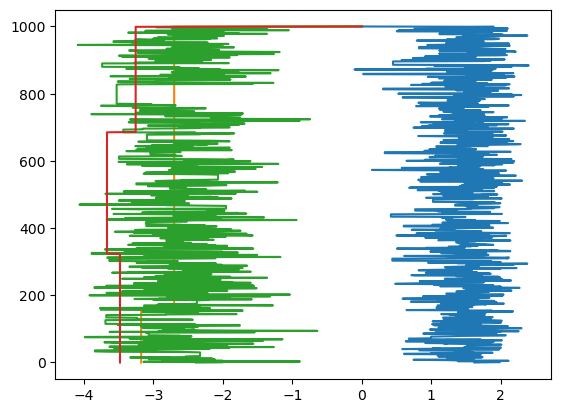

In [146]:
plt.plot(chains[0,:,:].T, range(len(chains[0,:,:].T)));

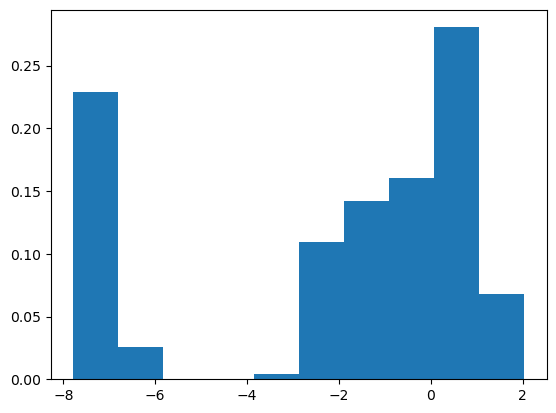

In [155]:
plt.hist(chains[0].flatten(),density=True);

In [163]:
def MetropolisHastings(prior, likelihood, niters=1000, nburnin=100, lag=1, nchains=4, sigma_proposal=1):
    
    d = len(prior)
    proposal = cp.Iid(cp.Normal(), d)
    test = cp.Uniform()
    particles = prior.sample(nchains)
    pi_particles = prior.pdf(particles)
    for n in range(nchains):
        particle = particles[...,n]
        if pi_particles[n] == 0: 
            pi_particles[n] = np.sqrt(np.finfo(float).eps)
            continue
        pi_particles[n] *= likelihood(*particle)
    u = prior.fwd(particles)
    norm_particles = proposal.inv(u)
    
    chains = np.zeros((d, nchains, niters+1))
    chains[...,0] = particles
    
    naccepted = 0
    total = (niters + nburnin)
    with tqdm(total=total, position=0) as pbar:
        for j in range(total):
            
            i = j - nburnin
            for _ in range(lag):
                
                # norm_candidates = norm_particles + sigma_proposal*proposal.sample(nchains)
                # u = proposal.fwd(norm_candidates)
                # candidates = prior.inv(u)
                
                for n in range(nchains):
                    norm_particle = norm_particles[...,n].reshape(-1,1)
                    norm_candidate = norm_particle + sigma_proposal*proposal.sample()
                    u = proposal.fwd(norm_candidate)
                    candidate = prior.inv(u)
                    
                    particle = particles[...,n]
                    pi_particle = pi_particles[...,n]
                    
                    # candidate = candidates[...,n]
                    pi_candidate = prior.pdf(candidate)
                    if pi_candidate != 0:
                        pi_candidate *= likelihood(*candidate)
                        
                    accept_ratio = min(1, pi_candidate/pi_particle)
                        
                    if test.sample() < accept_ratio:
                        particles[...,n] = candidate.reshape(d)
                        norm_particles[...,n] = norm_candidate.reshape(d)
                        pi_particles[...,n] = pi_candidate
                        naccepted += 1
            
            pbar.update()
            pbar.set_description(f'Accept ratio: {naccepted/((j+1)*lag*nchains)*100:.3f}%')
            if i >= 0:
                chains[...,i] = particles
                
    
    return chains
chains = MetropolisHastings(prior, lambda *theta: likelihood(theta, t, Z_obs))

Accept ratio: 5.633%:  52%|█████▏    | 577/1100 [00:02<00:02, 203.05it/s] 


KeyboardInterrupt: 

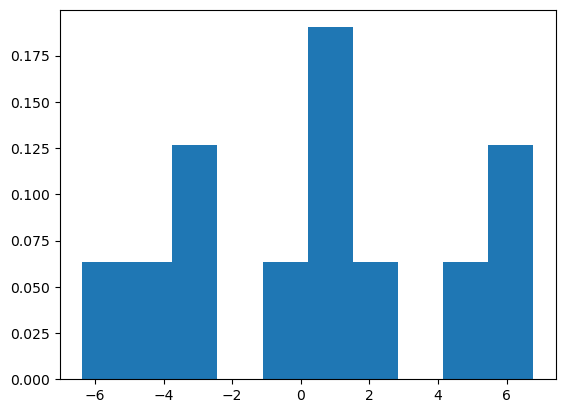

In [78]:
plt.hist(chains[...,0].flatten(),density=True);